In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
import sys

from tqdm import tqdm_notebook
from fake_useragent import UserAgent

In [75]:
url_main = "https://www.flightconnections.com/"
url_codes = "airport-codes"

In [168]:
res = requests.get(url_main + url_codes, headers={'User-Agent': UserAgent().chrome})
html = res.content
soup = BeautifulSoup(html, 'lxml')

In [78]:
def get_soup(url):
    res = requests.get(url, headers={'User-Agent': UserAgent().chrome})
    html = res.content
    soup = BeautifulSoup(html, 'lxml')
    return soup

In [171]:
airport_list = soup.findAll("ul", attrs={"class":"airport-list"})
len(airport_list)

26

In [172]:
airport_list = [airport_group.findAll("li") for airport_group in airport_list]

In [173]:
airport_list = sum(airport_list, [])

In [174]:
len(airport_list)

3925

In [61]:
airport = airport_list[0]
airport

<li>
<a href="/flights-from-anaa-aaa" title="">
<div class="country-airports-info">
<p class="airport-city"><span class="airport-code">AAA</span><span class="airport-city-country">Anaa, French Polynesia</span></p>
<p><span class="airport-name">Anaa Airport</span></p>
</div>
</a>
</li>

In [24]:
link = airport.find("a").get("href")
link

'/flights-from-anaa-aaa'

In [26]:
code = airport.find("span", attrs={"class":"airport-code"}).text
code

'AAA'

In [27]:
name = airport.find("span", attrs={"class":"airport-name"}).text
name

'Anaa Airport'

In [32]:
city, country = airport.find("span", attrs={"class":"airport-city-country"}).text.split(",")
city, country = city.strip(), country.strip()
city, country

('Anaa', 'French Polynesia')

In [34]:
from typing import Dict, List

In [43]:
def get_airport_info(airport)->Dict[str,str]:
    """
    Get the following info:
        - name
        - code
        - link
        - city_country
    
    :airport: bs4.element.Tag
        current airport info from bs4
        
    returns: Dict
        parsed airport information
    """
    link = airport.find("a").get("href")
    code = airport.find("span", attrs={"class":"airport-code"}).text
    name = airport.find("span", attrs={"class":"airport-name"}).text
    city_country = airport.find("span", attrs={"class":"airport-city-country"}).text    
    return {"link":link, "code":code, "name":name, "city_country":city_country}

In [62]:
airport_info = []

for airport in tqdm_notebook(airport_list):
    airport_info.append(get_airport_info(airport))

In [64]:
airport_info = pd.DataFrame(airport_info)
airport_info

,link,code,name,city_country
0,/flights-from-anaa-aaa,AAA,Anaa Airport,"Anaa, French Polynesia"
1,/flights-from-annaba-aae,AAE,Rabah Bitat Airport (Les Salines,"Annaba, Algeria"
2,/flights-from-aranuka-aak,AAK,Aranuka Airport,"Aranuka, Kiribati"
3,/flights-from-aalborg-aal,AAL,Aalborg Airport,"Aalborg, Denmark"
4,/flights-from-al-ain-aan,AAN,Al Ain International Airport,"Al Ain, United Arab Emirates"
...,...,...,...,...
3920,/flights-from-savannakhet-zvk,ZVK,Savannakhet Airport,"Savannakhet, Laos"
3921,/flights-from-wollaston-lake-zwl,ZWL,Wollaston Lake Airport,"Wollaston Lake, Canada"
3922,/flights-from-zunyi-zyi,ZYI,Zunyi Airport,"Zunyi, China"
3923,/flights-from-sylhet-zyl,ZYL,Osmani International Airport,"Sylhet, Bangladesh"


In [196]:
airport_info.to_csv("airport_info.csv")

In [112]:
url_airport = airport_info.link[0]
source_airport = airport_info.code[0]
url_airport, source_airport

('/flights-from-anaa-aaa', 'AAA')

In [80]:
flights_info = get_soup(url_main + url_airport)

In [86]:
popular_destinations = flights_info.find("div", attrs={"class":"popular-destinations-list"})
popular_destinations = popular_destinations.findAll("div", attrs={"class":"popular-destination"})
popular_destinations

[<div class="popular-destination" data-a="Tahiti (PPT)" data-c="5905"><div class="country-img"><img alt="French Polynesia" src="/flags/24/PF.png" title="French Polynesia"/></div><div class="popular-destination-airport-name">Tahiti (PPT)</div><span class="float-right"> 6 flights / month</span></div>,
 <div class="popular-destination" data-a="Faaite (FAC)" data-c="2565"><div class="country-img"><img alt="French Polynesia" src="/flags/24/PF.png" title="French Polynesia"/></div><div class="popular-destination-airport-name">Faaite (FAC)</div><span class="float-right"> 0 flights / month</span></div>,
 <div class="popular-destination" data-a="Makemo (MKP)" data-c="5069"><div class="country-img"><img alt="French Polynesia" src="/flags/24/PF.png" title="French Polynesia"/></div><div class="popular-destination-airport-name">Makemo (MKP)</div><span class="float-right"> 0 flights / month</span></div>,
 <div class="popular-destination" data-a="Raroia (RRR)" data-c="6161"><div class="country-img"><i

In [88]:
destination = popular_destinations[0]
destination

<div class="popular-destination" data-a="Tahiti (PPT)" data-c="5905"><div class="country-img"><img alt="French Polynesia" src="/flags/24/PF.png" title="French Polynesia"/></div><div class="popular-destination-airport-name">Tahiti (PPT)</div><span class="float-right"> 6 flights / month</span></div>

In [90]:
destination_name = destination.find("div", attrs={'class':"popular-destination-airport-name"}).text
destination_name

'Tahiti (PPT)'

In [98]:
destination_code = re.findall("\((.*?)\)", destination_name)[0]
destination_code

'PPT'

In [101]:
destination_flights = destination.find("span", attrs={'class':"float-right"}).text.strip()
destination_flights

'6 flights / month'

In [102]:
destination_flights

'6 flights / month'

In [107]:
destination_flights = re.findall('\d+', destination_flights)[0]
if destination_flights.isdigit():
    destination_flights = int(destination_flights)
destination_flights

6

In [120]:
def _destination_info(destination, source_airport)->Dict[str,str]:
    """
    Get iformation on destination code and number of flights per month
    
    :destination: bs4.element.Tag
    
    :source_airport: str
        IATA code for the airport
    
    returns: Dict
        parsed destination info
    """
    
    destination_name = destination.find("div", attrs={'class':"popular-destination-airport-name"}).text
    destination_code = re.findall("\((.*?)\)", destination_name)[0]
    
    destination_flights = destination.find("span", attrs={'class':"float-right"}).text.strip()
    destination_flights = re.findall('\d+', destination_flights)[0]
    if destination_flights.isdigit():
        destination_flights = int(destination_flights)
        
    return {"sourse_code": source_airport, 
            "destination_code":destination_code, 
            "destination_flights":destination_flights}

In [121]:
_destination_info(destination, source_airport)

{'course_code': 'AAA', 'destination_code': 'RRR', 'destination_flights': 0}

In [122]:
destinations_info = []
for destination in popular_destinations:
    destinations_info.append(_destination_info(destination, source_airport))

In [123]:
pd.DataFrame(destinations_info)

,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,FAC,0
2,AAA,MKP,0
3,AAA,RRR,0


In [126]:
def get_destinations_info(url_airport, source_airport)->List[Dict]:
    """
    Get destination code and number of flights for all destinations
    
    :url_airport: string
    :source_airport: string
    """
    flights_info = get_soup(url_main + url_airport)
    
    popular_destinations = flights_info.find("div", attrs={"class":"popular-destinations-list"})
    popular_destinations = popular_destinations.findAll("div", attrs={"class":"popular-destination"})
    
    destinations_info = []
    for destination in popular_destinations:
        destinations_info.append(_destination_info(destination, source_airport))
        
    return destinations_info  

In [125]:
get_destinations_info(url_airport, source_airport)

[{'course_code': 'AAA', 'destination_code': 'PPT', 'destination_flights': 6},
 {'course_code': 'AAA', 'destination_code': 'RRR', 'destination_flights': 0},
 {'course_code': 'AAA', 'destination_code': 'FAC', 'destination_flights': 0},
 {'course_code': 'AAA', 'destination_code': 'MKP', 'destination_flights': 0}]

In [143]:
list(airport_info.itertuples())[0]

Pandas(Index=0, link='/flights-from-anaa-aaa', code='AAA', name='Anaa Airport', city_country='Anaa, French Polynesia')

## An interesting comparison

In [138]:
%%timeit
for row in airport_info.iterrows():
    pass

255 ms ± 8.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [140]:
%%timeit
for row in airport_info.itertuples():
    pass

3.04 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Final parsing

In [200]:
full_destination_routes = []

exceptions = []

for row in tqdm_notebook(airport_info.itertuples(), total=airport_info.shape[0]):
    url_airport = row.link
    source_airport = row.code
    try:
        full_destination_routes.extend(get_destinations_info(url_airport, source_airport))
    except Exception as e:
        if e == KeyboardInterrupt:
            break            
        else:
            print(e, url_airport, source_code)
        exceptions.append([e, url_airport, source_code])
    time.sleep(0.5)

'NoneType' object has no attribute 'findAll' /flights-from-annaba-aae ZZU
'NoneType' object has no attribute 'findAll' /flights-from-cherepovets-cee ZZU
'NoneType' object has no attribute 'findAll' /flights-from-cotonou-coo ZZU
'NoneType' object has no attribute 'findAll' /flights-from-dnipro-dnk ZZU
'NoneType' object has no attribute 'findAll' /flights-from-friedrichshafen-fdh ZZU
'NoneType' object has no attribute 'findAll' /flights-from-kherson-khe ZZU
'NoneType' object has no attribute 'findAll' /flights-from-n-djamena-ndj ZZU
'NoneType' object has no attribute 'findAll' /flights-from-saarbr%C3%BCcken-scn ZZU


In [201]:
pd.DataFrame(full_destination_routes).to_csv("routes.csv")

In [202]:
result = pd.DataFrame(full_destination_routes)

In [203]:
result.shape

(28330, 3)

In [205]:
result

,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
4,AAK,TRW,12
...,...,...,...
28325,ZYL,JED,0
28326,ZYL,LHR,0
28327,ZYL,MCT,0
28328,ZZU,LIX,17


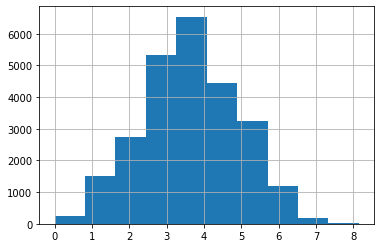

In [207]:
result.destination_flights[result.destination_flights>0].apply(np.log).hist()

--- 

## Population

In [209]:
population_link = "http://worldpopulationreview.com/world-cities/"

In [210]:
soup = get_soup(population_link)

In [212]:
table = soup.find("table", attrs={"class":"datatableStyles__StyledTable-bwtkle-1 hOnuWY table table-striped"})

In [220]:
population = pd.read_html(str(table))[0]
population

,Rank,Name,2020 Population,2019 Population,Change
0,1,Tokyo,37393129,37435191,-0.11%
1,2,Delhi,30290936,29399141,3.03%
2,3,Shanghai,27058479,26317104,2.82%
3,4,Sao Paulo,22043028,21846507,0.90%
4,5,Mexico City,21782378,21671908,0.51%
...,...,...,...,...,...
1718,1719,Kurume,304865,305335,-0.15%
1719,1720,Orlando,303933,290553,2.25%
1720,1721,Pittsburgh,302669,303147,-0.08%
1721,1722,Vladikavkaz,302105,303891,-0.59%


In [221]:
population.to_csv("city_population.csv")